In [192]:
from cmlreaders import CMLReader, get_data_index
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats

In [193]:
site = 'Jefferson'
sel_sub = pd.DataFrame([])
subs = []
df = pd.read_excel(r'./' + site + '_neuropsych.xlsx')
for i in df.index:
    gap = df.iloc[i]['Time between report and implant (days)']
    BDI = df.iloc[i]['BDI']
    BAI = df.iloc[i]['BAI']
    sub = df.iloc[i]['Subject Number']
    if gap < 183 and np.isnan(BDI)==False and np.isnan(BAI)==False:
        sel_sub = sel_sub.append({
            'subject':sub,
            'BDI':BDI,
            'BAI':BAI
            }, ignore_index = True)
sel_sub

,BAI,BDI,subject
0,0.0,2.0,8.0
1,14.0,22.0,19.0
2,3.0,1.0,22.0
3,7.0,6.0,49.0
4,20.0,30.0,51.0
5,17.0,5.0,55.0
6,11.0,13.0,59.0
7,9.0,21.0,73.0
8,0.0,11.0,81.0
9,9.0,19.0,83.0


In [194]:
df = get_data_index('r1')
df_subs = df['subject'].unique()
df_select = pd.DataFrame([])
df_subs
tmp = []
select = []
for sub in df_subs:
    num = int(sub[2:5])
    for i in sel_sub.index:
        sel = sel_sub.iloc[i]['subject']
        if sel == num:
            df_select = df_select.append({
                'subject':sub,
                'BDI':sel_sub.iloc[i]['BDI'],
                'BAI':sel_sub.iloc[i]['BAI']
                }, ignore_index = True)

df_select

,BAI,BDI,subject
0,0.0,2.0,R1008J
1,14.0,22.0,R1019J
2,3.0,1.0,R1022J
3,7.0,6.0,R1049J
4,20.0,30.0,R1051J
5,11.0,13.0,R1059J
6,9.0,21.0,R1073J
7,0.0,11.0,R1081J
8,9.0,19.0,R1083J
9,20.0,6.0,R1093J


In [196]:
trial_df = pd.DataFrame([])
for sub in df_select['subject']: ### 'sub' instead of 's' 
    try:
        exp = 'catFR1'
        localizations=df[(df['subject']==sub) & (df['experiment']==exp)]['localization'].unique()        
        
        for loc in localizations:
            montages = df[(df['subject']==sub) & (df['experiment']==exp) & (df['localization']==loc)]['montage'].unique()            
            
            for mont in montages: # iterate over montages            
                data = df[np.logical_and(df["subject"] == sub, df['experiment']==exp)]
                sessions=data[np.logical_and(data['montage']==mont,data['localization']==loc)]['session'].unique()
                
                for sess in sessions: # 'sess' instead of 'k' 
                    reader = CMLReader(sub, exp, sess, montage=mont, localization=loc)   #reader for loading CML data
                    evs = reader.load('task_events')
                    word_evs = evs[evs['type']=='REC_WORD']
#                     rec_evs = word_evs[word_evs['recalled']==True]
                    s_dict = {} #create variables for each field and then append using Noa's technique

                    ### many times there are negative lists, referring to practice lists. You want to
                    # exclude those: word_evs['list'][word_evs['list']>0].unique() 
                    lists = len(word_evs['list'][word_evs['list']>0].unique()) 
                    corr_recs = len(word_evs[word_evs['intrusion']==0]) # changed
                    ELIs = len(word_evs[word_evs['intrusion']==-1])
                    PLIs = len(word_evs[word_evs['intrusion']>0])
                    total_ints = ELIs + PLIs
                    total_trials = corr_recs + total_ints

                    trials = []
                    for list_num in word_evs['list'][word_evs['list']>0].unique():
                        list_events=word_evs[word_evs['list']==list_num]
                        if len(list_events)>0: 
                            for i in range(0,len(list_events)):
                                trials.append(list_events.index[i])               

                    #add line to dataframe if trials satisfy exclusion criteria (5 or more events per type
                    trial_df = trial_df.append({
                        'subject':sub,
                        'session': sess,
                        'montage': mont,
                        'localization': loc,
                        'experiment': exp,
                        'number of lists': lists,
                        'number of correct recalls': corr_recs,
                        'number of extra-list intrusions': ELIs,
                        'number of prior-list intrusions': PLIs,
                        'total number of intrusions': total_ints,
                        'total number of trials left': total_trials,
                        'trials for analysis': trials
                        },ignore_index=True )  
    except:
        continue

In [197]:
df_filter = pd.DataFrame([])

for i in trial_df.index:
    try:
        sub = trial_df.iloc[i]['subject']
        row = df_select[df_select['subject'] == sub]
        eli = trial_df.iloc[i]['number of extra-list intrusions']
        pli = trial_df.iloc[i]['number of prior-list intrusions']
        correc = trial_df.iloc[i]['number of correct recalls']
        lists = trial_df.iloc[i]['number of lists']
        sc_correc = float(correc/lists)*25
        sceli = float(eli/lists)*25
        scpli = float(pli/lists)*25
        df_filter = df_filter.append({
            'subject':sub,
            'correct recalls':correc,
            'ELIs':eli,
            'PLIs':pli,
            'total ints': eli+pli,
            'lists':lists,
            'correct recalls scaled':sc_correc,
            'ELI scaled':sceli,
            'PLI scaled':scpli,
            'total scaled':sceli+scpli,
            'BAI':int(row['BAI'].values),
            'BDI':int(row['BDI'].values)
        }, ignore_index = True)
    except:
        continue
df_filter

,BAI,BDI,ELI scaled,ELIs,PLI scaled,PLIs,correct recalls,correct recalls scaled,lists,subject,total ints,total scaled
0,9.0,19.0,20.000000,4.0,0.000000,0.0,5.0,25.000000,5.0,R1083J,4.0,20.000000
1,20.0,6.0,1.041667,1.0,1.041667,1.0,86.0,89.583333,24.0,R1093J,2.0,2.083333
2,1.0,6.0,3.000000,3.0,2.000000,2.0,157.0,157.000000,25.0,R1107J,5.0,5.000000
3,1.0,6.0,1.250000,1.0,2.500000,2.0,149.0,186.250000,20.0,R1107J,3.0,3.750000
4,1.0,1.0,0.000000,0.0,7.000000,7.0,138.0,138.000000,25.0,R1108J,7.0,7.000000
5,1.0,1.0,1.086957,1.0,2.173913,2.0,108.0,117.391304,23.0,R1108J,3.0,3.260870
6,1.0,1.0,0.000000,0.0,3.000000,3.0,107.0,107.000000,25.0,R1108J,3.0,3.000000
7,1.0,1.0,2.000000,2.0,3.000000,3.0,151.0,151.000000,25.0,R1108J,5.0,5.000000
8,4.0,41.0,3.260870,3.0,4.347826,4.0,64.0,69.565217,23.0,R1266J,7.0,7.608696
9,4.0,41.0,11.250000,9.0,8.750000,7.0,42.0,52.500000,20.0,R1266J,16.0,20.000000


In [222]:
avg_df = pd.DataFrame([])
sub_df = df_filter['subject'].unique()
for sub in sub_df:
    trials = df_filter[df_filter['subject']==sub]
    df_mean = trials.mean(axis=0)
    avg_eli = df_mean['ELI scaled']
    avg_pli = df_mean['PLI scaled']
    avg_int = df_mean['total scaled']
    avg_cor = df_mean['correct recalls scaled']
    avg_df = avg_df.append({
        'subject':sub,
        'average ELIs':avg_eli,
        'average PLIs':avg_pli,
        'average ints': avg_int,
        'average correct recalls':avg_cor,
        'BAI':df_mean['BAI'],
        'BDI':df_mean['BDI']
        }, ignore_index = True)
avg_df

,BAI,BDI,average ELIs,average PLIs,average correct recalls,average ints,subject
0,9.0,19.0,20.000000,0.000000,25.000000,20.000000,R1083J
1,20.0,6.0,1.041667,1.041667,89.583333,2.083333,R1093J
2,1.0,6.0,2.125000,2.250000,171.625000,4.375000,R1107J
3,1.0,1.0,0.771739,3.793478,128.347826,4.565217,R1108J
4,4.0,41.0,7.956722,9.659738,57.004400,17.616460,R1266J
5,5.0,16.0,8.240741,28.407407,79.555556,36.648148,R1286J
6,0.0,1.0,56.250000,25.000000,72.916667,81.250000,R1343J
7,10.0,11.0,1.041667,1.041667,123.390152,2.083333,R1384J
8,14.0,29.0,6.865530,8.428030,95.407197,15.293561,R1389J
9,6.0,5.0,16.666667,29.166667,127.083333,45.833333,R1398J


r =  -0.2313960695598254 p =  0.35555046115701616
y = -0.45538134264293084 *x +  15.92676816761977


Text(0.5, 1.0, 'BAI vs average ELIs')

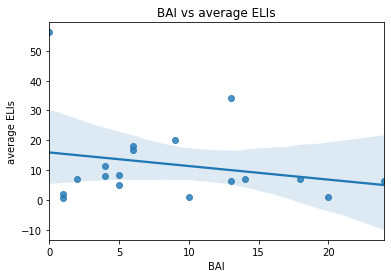

In [229]:
xi = 'BAI'
yi = 'average ELIs'

# x = df_filter[xi]
# y = df_filter[yi]

x = avg_df[xi]
y = avg_df[yi]

coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)
grad, inter, r, p, std_err = stats.linregress(x, y)

# plt.figure(figsize=(8, 8))
# plt.scatter(x, y)
# plt.plot(x, poly1d_fn(x), '--k')
# max_x = round(x.max(axis = 0) + 5, 5)
# max_y = round(y.max(axis = 0) + 5, 5)
# plt.xticks(np.arange(0, max_x, 5))
# plt.yticks(np.arange(0, max_y, 10))
# plt.xlabel(xi)
# plt.ylabel(yi)
print('r = ',r, 'p = ', p)
print('y =', grad, '*x + ', inter)
fig, ax = plt.subplots()
sb.regplot(data = df_filter, x=x, y=y, ax=ax)
plt.title(xi + ' vs ' + yi)
# ax.set_xlim(0, 25)
# ax.set_xticks(range(0,25), 5)
#add error bars, combine FR/pyFR, catFR separate, check out Courier
#remove 5s and 4 intrusion criteria